In [1]:
###### @authors: Lasith Adhikari and Anusha Madushani  #####
############ Created on Mar 22, 2020 (Python 3)############
# Updated on Aug 30, 2020
# Code description: 
# Detect and label for VAC events for mechanically ventialted patients - grouped version for Fio2 and Peep

In [16]:
## Imports all the packages. 
import numpy as np
import pandas as pd
import os
import pdb

import random
from IPython.core.display import display, HTML
import scipy.stats as stats
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt

# from google.colab import auth
# from google.cloud import bigquery
# from google.colab import files
import os
import datetime

In [3]:
auth.authenticate_user() # authenticating 

In [4]:
# from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# path to base folder (right click on the directory: SCCM 2020 Datathon, and select 'Add to my Drive' in order to appear on My Drive)
# drive_folder = '/content/drive/My Drive/SCCM 2020 Datathon/' 

drive_folder = '/labs/kamaleswaranlab/resp_failure/data/VAC data/'

In [6]:
# Note that this should be the project for the datathon work
project_id = 'sccm-datathon'
os.environ['GOOGLE_CLOUD_PROJECT'] = project_id

# Read data from BigQuery into pandas dataframes.
def run_query(query):
  return pd.io.gbq.read_gbq(
      query,
      project_id=project_id,
      dialect='standard')

In [4]:
# function to label VAC or NO VAC for a given patient data - grouped version 
def is_VAC(df_, peep_change='low', fio2_change='low', min_baseline_period=2):

  # define groups:
  peep_gps = {'low':[0.99,3], 'med':[3,6], 'high':[6,100]} # Low=[1:3], Med=(3:6], High>6
  fio2_gps = {'low':[9.99,20], 'med':[20,50], 'high':[50,100]} # low=[10:20], med=(20:50], high>50

  # replace all 0 to 5  peep by 5:
  df = df_.copy()
  df.loc[(df['min_peep']>=0) & (df['min_peep']<=5), 'min_peep'] = 5

  for index, row in df.iterrows():

    peep_missing = False
    fio2_missing = False
    stable = np.nan

    if index >= min_baseline_period:

      #### check for stability end ####

      if ~df.loc[index-min_baseline_period: index-1,'min_peep'].isnull().any(): 
        # PEEP:
        if np.sum(df.loc[index-min_baseline_period: index-1,'min_peep'].diff()>0) == 0:
          peep_stable = True
        else:
          peep_stable = False
      else:
        peep_missing = True
    
      # FIO2:
      if ~df.loc[index-min_baseline_period: index-1,'min_fio2'].isnull().any(): 
        if np.sum(df.loc[index-min_baseline_period: index-1,'min_fio2'].diff()>0) == 0:
          fio2_stable = True
        else:
          fio2_stable = False
      else:
        fio2_missing = True

      if (peep_missing & fio2_missing):
        continue
      elif (peep_missing & ~fio2_missing):
        stable = fio2_stable
      elif (~peep_missing & fio2_missing):
        stable = peep_stable
      else:
        stable = (peep_stable & fio2_stable)

      #print(index)
      if not stable:
        if index == min_baseline_period:
          continue
        else: 
          break
      
  # pick max value within the stable baseline period: i.e. same as the first day value of the baseline period
  max_peep_stability_period = df.loc[index-min_baseline_period-1: index-min_baseline_period,'min_peep'].max()
  max_fio2_stability_period = df.loc[index-min_baseline_period-1: index-min_baseline_period,'min_fio2'].max()

  
  # generate variables to check if the worsening oxygenation period was sustained for 2 periods
  IsPeep_decs =  np.sum(df.loc[index-1: index,'min_peep'].diff()<0) # >0 if PEEP decreased after instability?
  IsFio2_decs =  np.sum(df.loc[index-1: index,'min_fio2'].diff()<0) # >0 if FiO2 decreased after instability?

  peep_change_now = (df.loc[index-1,'min_peep'] - max_peep_stability_period)
  fio2_change_now = (df.loc[index-1,'min_fio2'] - max_fio2_stability_period)
  isPeepChange_significant = (peep_change_now > peep_gps[peep_change][0]) & (peep_change_now <= peep_gps[peep_change][1])
  isFiO2Change_significant = (fio2_change_now > fio2_gps[fio2_change][0]) & (fio2_change_now <= fio2_gps[fio2_change][1])

  if (isPeepChange_significant & (IsPeep_decs==0)):
    return (row['patientunitstayid'], df.loc[index-2,'time_hr'], df.loc[index-1,'time_hr'], 'VAC', stable)
  elif (isFiO2Change_significant & (IsFio2_decs==0)):
    return (row['patientunitstayid'], df.loc[index-2,'time_hr'], df.loc[index-1,'time_hr'], 'VAC', stable)
  else:
    return (row['patientunitstayid'], df.loc[index-2,'time_hr'], df.loc[index-1,'time_hr'], 'No VAC', stable)


In [5]:
# set the variable 'df_data_file' to the dataset that you are interested from the above list
df_data_file = 'clean MIMIC/24/Complete_MIMIC_24_MV_final.csv'
# 'data/MIMIC/1st_vent_ICU/24/MIMIC_24_MV_final.csv'  # CHANGE HERE
df_data = pd.read_csv(drive_folder + df_data_file) # read the dataset to df_data

# check for atleast 4 time periods for given id:
periods_per_id = df_data.groupby('patientunitstayid')['time_hr'].count()>=4
df_data = df_data[df_data.patientunitstayid.isin(periods_per_id[periods_per_id==True].index)].reset_index(drop=True)

# forward filling peep and fio2 within each id 
df_data.min_peep = df_data.groupby('patientunitstayid')['min_peep'].ffill()
df_data.min_fio2 = df_data.groupby('patientunitstayid')['min_fio2'].ffill()

# define grid of FiO2 and Peep values to be tested
delta_fio2  = ['low', 'med', 'high']    # CHANGE HERE. 
delta_peep  = ['low', 'med', 'high']    # CHANGE HERE. 

# define a dictionary to assign results and input parameters 
df_results = {'patientunitstayid': [], 'delta_fio2':[], 'delta_peep':[], 'unstable_start': [], 'unstable_end': [], 'VAC_outcome': [], 'IsStable':[]}

for d_fio2 in delta_fio2:
  for d_peep in delta_peep:
    print('Current iteration: delta_Fio2:',d_fio2, ',delta_Peep:',d_peep)
    i = 1 
    for enct_i in df_data.patientunitstayid.unique():
      df_i = df_data[df_data.patientunitstayid==enct_i].sort_values(by='time_hr').reset_index(drop=True)
      if (i%1000==0):
        print(i, 'patientunitstayids done...')
      result_i = is_VAC(df_i, peep_change=d_peep, fio2_change=d_fio2, min_baseline_period = 2)
      df_results['patientunitstayid'].append(result_i[0])
      df_results['delta_fio2'].append(d_fio2)
      df_results['delta_peep'].append(d_peep)
      df_results['unstable_start'].append(result_i[1])
      df_results['unstable_end'].append(result_i[2])
      df_results['VAC_outcome'].append(result_i[3])
      df_results['IsStable'].append(result_i[4])
      i+=1
df_results = pd.DataFrame(df_results)
df_results['VAC'] = df_results.VAC_outcome.apply(lambda x: 1 if x == 'VAC' else 0) # cat code for VAC label 

Current iteration: delta_Fio2: low ,delta_Peep: low
1000 patientunitstayids done...
2000 patientunitstayids done...
3000 patientunitstayids done...
4000 patientunitstayids done...
Current iteration: delta_Fio2: low ,delta_Peep: med
1000 patientunitstayids done...
2000 patientunitstayids done...
3000 patientunitstayids done...
4000 patientunitstayids done...
Current iteration: delta_Fio2: low ,delta_Peep: high
1000 patientunitstayids done...
2000 patientunitstayids done...
3000 patientunitstayids done...
4000 patientunitstayids done...
Current iteration: delta_Fio2: med ,delta_Peep: low
1000 patientunitstayids done...
2000 patientunitstayids done...
3000 patientunitstayids done...
4000 patientunitstayids done...
Current iteration: delta_Fio2: med ,delta_Peep: med
1000 patientunitstayids done...
2000 patientunitstayids done...
3000 patientunitstayids done...
4000 patientunitstayids done...
Current iteration: delta_Fio2: med ,delta_Peep: high
1000 patientunitstayids done...
2000 patientun

In [6]:
# Print results with VAC or No VAC label for each patient for different delta FiO2/Peep changes 
df_results

,patientunitstayid,delta_fio2,delta_peep,unstable_start,unstable_end,VAC_outcome,IsStable,VAC
0,200033.0,low,low,192,216,No VAC,True,0
1,200046.0,low,low,264,288,No VAC,False,0
2,200059.0,low,low,144,168,No VAC,True,0
3,200063.0,low,low,96,120,VAC,False,1
4,200065.0,low,low,144,168,VAC,False,1
...,...,...,...,...,...,...,...,...
43789,299903.0,high,high,96,120,No VAC,True,0
43790,299925.0,high,high,120,144,No VAC,False,0
43791,299956.0,high,high,48,72,No VAC,False,0
43792,299963.0,high,high,72,96,No VAC,True,0


In [24]:
#df_results.to_csv('MIMIC_1st_vent_ICU_VAC_24hr_grouped_Aug30.csv',index=False)
#files.download('MIMIC_1st_vent_ICU_VAC_24hr_grouped_Aug30.csv')

# load saved df_results data if needed:
#df_result_file = 'Results/eICU/eICU_1st_vent_ICU_VAC_24hr_jun20.csv'  # CHANGE HERE
#df_results = pd.read_csv(drive_folder + df_result_file) # read the dataset to df_data

df_results.to_csv(
    drive_folder + 'clean MIMIC/24/MIMIC_1st_vent_ICU_VAC_24hr_grouped.' + 
    datetime.datetime.now().strftime('%Y%m%d') + '.csv',
    index=False, header=True)

## NoVAC/VAC label vs. clinical outcome: Mortaility

### Read mortality  outcome data

In [9]:
df_status = pd.read_csv(drive_folder + "MIMIC/mimic_hospital_mortality.csv") # read hospital mortality outcome for MIMIC
df_status.rename(columns={'hospital_expire_flag':'Inhospital_mortality','icustay_id':'patientunitstayid' }, inplace=True)

In [10]:
df_status.head()

,subject_id,hadm_id,patientunitstayid,Inhospital_mortality
0,268,110404,280836,1
1,269,106296,206613,0
2,270,188028,220345,0
3,271,173727,249196,0
4,272,164716,210407,0


In [11]:
# ditribution of data
df_status.Inhospital_mortality.value_counts()

0    54923
1     6609
Name: Inhospital_mortality, dtype: int64

In [12]:
# Merge outcome:
df_vac_mortality = pd.merge(df_results, df_status, how='left', on='patientunitstayid' )

# drop rows without mortality outcome:
df_vac_mortality = df_vac_mortality[~df_vac_mortality.Inhospital_mortality.isnull()]

# convert Inhospital_mortality to int
df_vac_mortality.Inhospital_mortality = df_vac_mortality.Inhospital_mortality.astype('int8')

In [13]:
df_vac_mortality['hospitaldischargestatus'] =  df_vac_mortality['Inhospital_mortality'].apply(lambda x: 'Expired' if x == 1 else 'Alive')

In [14]:
df_vac_mortality.head()

,patientunitstayid,delta_fio2,delta_peep,unstable_start,unstable_end,VAC_outcome,IsStable,VAC,subject_id,hadm_id,Inhospital_mortality,hospitaldischargestatus
0,200033.0,low,low,192,216,No VAC,True,0,56369,198650,1,Expired
1,200046.0,low,low,264,288,No VAC,False,0,6476,112040,0,Alive
2,200059.0,low,low,144,168,No VAC,True,0,28494,199133,0,Alive
3,200063.0,low,low,96,120,VAC,False,1,99052,129142,0,Alive
4,200065.0,low,low,144,168,VAC,False,1,19891,112840,0,Alive


In [23]:
# #df_vac_outcome.to_csv('eICU_1st_vent_ICU_VAC_24hr_outcomes.csv',index=False)
# df_vac_mortality.to_csv('MIMIC_1st_vent_ICU_VAC_24hr_outcomes_grouped_Aug30.csv',index=False)  # 
# files.download('MIMIC_1st_vent_ICU_VAC_24hr_outcomes_grouped_Aug30.csv')

df_vac_mortality.to_csv(
    drive_folder + 'clean MIMIC/day/MIMIC_1st_vent_ICU_VAC_24hr_outcomes_grouped.' + 
    datetime.datetime.now().strftime('%Y%m%d') + '.csv',index=False, header=True)
# files.download('MIMIC_1stICUVent_VAC_vs_mortality_CalDay_july21.csv')

## Analytics for each parameter setting

In [18]:
df_vac_outcome = df_vac_mortality.copy()

# Outcome:Mortality

In [19]:
OR_results = {}
outcome_ = 'hospitaldischargestatus'

# define grid of FiO2 and Peep values to be tested
delta_fio2  = ['low', 'med', 'high']  # CHANGE HERE
delta_peep  = ['low', 'med', 'high']  # CHANGE HERE

for d_fio2 in delta_fio2:
  OR_results['dFio2:'+str(d_fio2)] = []
  for d_peep in delta_peep:
    print('Current parameter setting: delta_Fio2:',d_fio2, ', delta_Peep:',d_peep)

    df_analytics = df_vac_outcome[(df_vac_outcome.delta_fio2==d_fio2) & (df_vac_outcome.delta_peep==d_peep)]

    # VAC distribution:
    print('VAC distribution(%):')
    vac_distn = np.round(df_analytics.VAC_outcome.value_counts()/df_analytics.VAC_outcome.value_counts().sum()*100,2)
    #print(vac_distn.to_frame())
    print(tabulate(vac_distn.to_frame(), headers='keys', tablefmt='psql'))

    # Outcome distribution:
    print('Mortality distribution(%):')
    outcom_distn = np.round(df_analytics[outcome_].value_counts()/df_analytics[outcome_].value_counts().sum()*100,2)
    #print(outcom_distn.to_frame())
    print(tabulate(outcom_distn.to_frame(), headers='keys', tablefmt='psql'))

    # crosstab:
    print('Confusion matrix:')
    tbl = np.round(pd.crosstab(df_analytics.VAC_outcome, df_analytics[outcome_], dropna=False), 2)
    print(tabulate(tbl, headers='keys', tablefmt='psql'))

    # crosstab - percentage
    #print('Confusion matrix (%):')
    #tbl_perc = np.round(pd.crosstab(df_analytics.VAC_outcome, df_analytics.hospitaldischargestatus, dropna=False)/df_analytics.patientunitstayid.nunique()*100, 2)  
    #print(tabulate(tbl_perc, headers='keys', tablefmt='psql'))

    # compute odd-ratio:
    oddsratio, pvalue = stats.fisher_exact(np.array(tbl))
    print("Odds ratio: ", round(oddsratio,3), ", p-value:", pvalue) 

    OR_results['dFio2:'+str(d_fio2)].append(round(oddsratio,3))

    print('##########################-------------------------###############################')

# for visualization, generate table with OR for all different param.
index_list = []
for d_peep in delta_peep:
    index_list.append('dPeep:'+str(d_peep))
OR_results_df = pd.DataFrame(OR_results, index=index_list) 

print('####################################    SUMMARY   ####################################')
print(tabulate(OR_results_df, headers='keys', tablefmt='psql'))


Current parameter setting: delta_Fio2: low , delta_Peep: low
VAC distribution(%):
+--------+---------------+
|        |   VAC_outcome |
|--------+---------------|
| No VAC |         77.85 |
| VAC    |         22.15 |
+--------+---------------+
Mortality distribution(%):
+---------+---------------------------+
|         |   hospitaldischargestatus |
|---------+---------------------------|
| Alive   |                      71.7 |
| Expired |                      28.3 |
+---------+---------------------------+
Confusion matrix:
+---------------+---------+-----------+
| VAC_outcome   |   Alive |   Expired |
|---------------+---------+-----------|
| No VAC        |    2788 |      1000 |
| VAC           |     701 |       377 |
+---------------+---------+-----------+
Odds ratio:  1.499 , p-value: 6.188447940281966e-08
##########################-------------------------###############################
Current parameter setting: delta_Fio2: low , delta_Peep: med
VAC distribution(%):
+--------+----

#### Odd ratio visualization

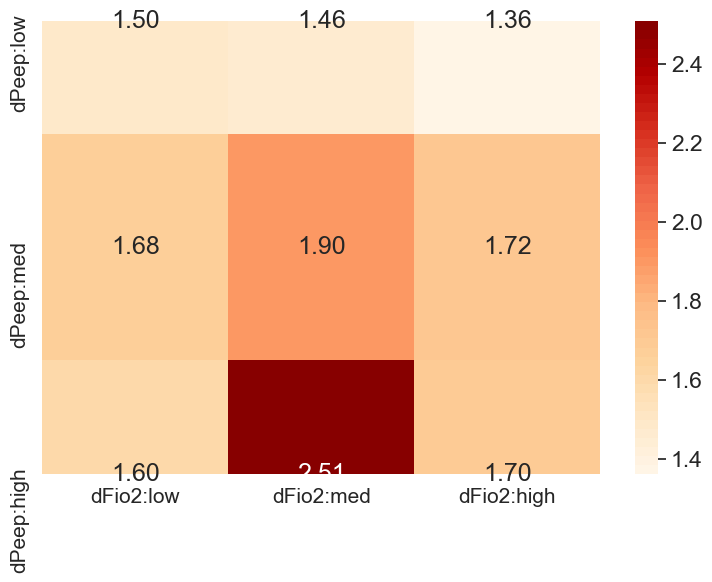

In [20]:
# 
sns.set(font_scale=1.5)  # crazy big
f, ax = plt.subplots(figsize=(9, 6), dpi=100)
ax = sns.heatmap(OR_results_df, annot=True, cmap=sns.color_palette("OrRd", 50), fmt='.2f')
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)